In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import constants, units
from astropy.coordinates import Angle
from scipy.optimize import curve_fit
import pandas as pd
import os
from scipy.signal import medfilt

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/MUSE/'

Load in the segmentation map for galaxy IDs

In [3]:
cat_file = np.loadtxt(rootdir + 'test_new_updated.cat')

In [4]:
gal_ids_arr = np.int_(cat_file[:,0])
z_ids_arr = cat_file[:,12]

In [5]:
gal_id = 1

In [6]:
idx = np.where(gal_ids_arr==gal_id)[0][0]

In [7]:
z_best = z_ids_arr[idx]

In [8]:
gal_spec_arr = np.loadtxt(rootdir+'gal{}/gal{}_spec.dat'.format(gal_id, gal_id), delimiter='\t')

In [9]:
wav_arr = gal_spec_arr[:,0]
gal_spec_raw = gal_spec_arr[:,1]
gal_spec_err = gal_spec_arr[:,2]
gal_spec_fit = gal_spec_arr[:,3]

In [12]:
B_center = 4450
B_fwhm = 940
B_sigma = B_fwhm/(2*np.sqrt(2*np.log(2)))

V_center = 5510
V_fwhm = 880
V_sigma = V_fwhm/(2*np.sqrt(2*np.log(2)))

In [16]:
n_span = 1

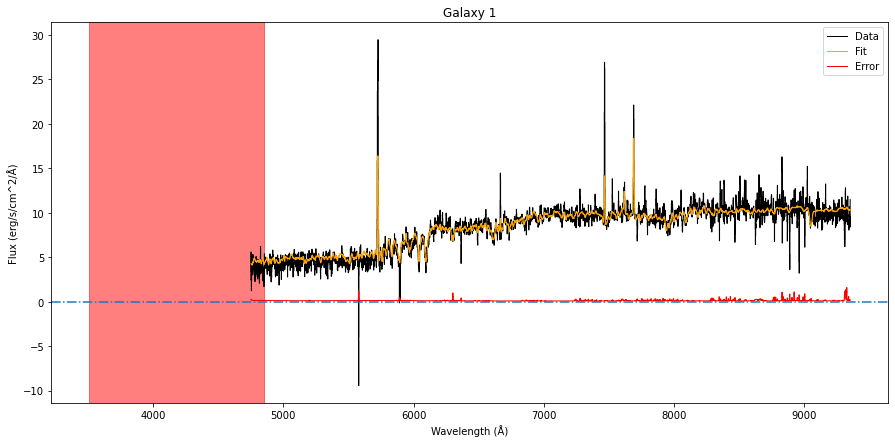

In [17]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.step(wav_arr, gal_spec_raw, label='Data', color='black', lw=1, where='mid')
ax.step(wav_arr, gal_spec_fit, label='Fit', color='orange', lw=1, where='mid')
ax.step(wav_arr, gal_spec_err, label='Error', color='red', lw=1, where='mid')

ax.axvspan(B_center-n_span*B_fwhm, B_center+n_span*B_sigma, alpha=0.5, color='red')

ax.axhline(0, linestyle='-.')

ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Flux (erg/s/cm^2/Å)')
ax.set_title('Galaxy {}'.format(gal_id))

ax.legend()

Next, compute photometry

First, we must find the stellar mass of the galaxy, which is given by -

$$\log_{10}(M_*/L_B) = a_B + b_B(B-V)$$

For a Bruzual & Charlot model with solar metallicity and a Salpeter (1955) IMF ($0.1–125 M_{\odot}$), $a_B =  −0.51$ and $b_B = 1.45$. This relation is taken from [Vulcani et al. 2013](https://www.aanda.org/articles/aa/full_html/2013/02/aa18388-11/aa18388-11.html#:~:text=Galaxy%20stellar%20masses%20are%20derived,0.51%20and%20bB%20%3D%201.45}).

There is a redshift dependence in here, I am certain, that would probably need a more careful examination of the paper. Therefore, to infer the stellar mass, the strategy would be to -

1. Compute the photometry of all galaxies (using MUSE spectra should be alright) and consequently the colors
2. Obtain the luminosity distance given the redshift (use [Hogg 2000](https://arxiv.org/pdf/astro-ph/9905116.pdf)), and adapting a cosmology, and then obtain the $B$ band luminosity

#### Note - I hope that the units of the mass-to-light ratio is $M_{\odot}/L_{\odot}$

Thereafter, we must compute the dark matter halo mass from the stellar mass, which is given by the following parametrization posited in [Moster et al. 2010](https://arxiv.org/abs/0903.4682) -

$$\frac{M_*}{M_h} = 2A(z)\left[ \left(\frac{M_h}{M_A(z)}\right)^{-\beta(z)}  + \left(\frac{M_h}{M_A(z)}\right)^{\gamma(z)} \right]^{-1}$$

While the parameters are difficult to compute exactly, [Girelli et al. 2020](https://arxiv.org/pdf/2001.02230.pdf) obtain a table of the parameters $A(z), M_A(z), \beta(z), \gamma(z)$ for various redshift bins. Adopting that table and solving the given relation non-linearly, we should be able to derive a solution for $M_h$, given the stellar mass derived from the previous step.

Finally, using [Zahid et al. 2018](https://iopscience.iop.org/article/10.3847/1538-4357/aabe31), we can relate the total dark matter velocity dispersion with the halo mass as follows -

$$\log_{10} \left( \frac{\sigma_{T, DM}}{100 \ \text{km/s}} \right) = \alpha_1 + \beta_1 \log_{10} \left( \frac{M_h}{10^{12}M_{\odot}} \right)$$

With $\alpha_1 = -0.007 \pm 0.001$ and $\beta_1 = 0.3 \pm 0.001$